This sample shows how to use the distribution strategy APIs when writing a custom training loop on TPU:
 * instantiate a `TPUStrategy()`
 * create the model and all other trainin objects in a strategy scope `with strategy.scope(): ...`
 * distribute the dataset with `strategy.experimental_distribute_dataset(ds)`
 * run the training step distributed with `strategy.run(step_fn)`
 * aggregate results returned by distributed workers with `strategy.reduce(...)`

## Imports

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import re, time
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0-dlenv


## TPU or GPU detection
TPUClusterResolver() automatically detects a connected TPU on all Gooogle's
platforms: Colaboratory, AI Platform (ML Engine), Kubernetes, Kaggle, ...

In [2]:
try: # detect TPUs
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: martin-tpuv3-8-tf22


INFO:tensorflow:Initializing the TPU system: martin-tpuv3-8-tf22


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


## Configuration and learning rate schedule

Learning rate schedule:


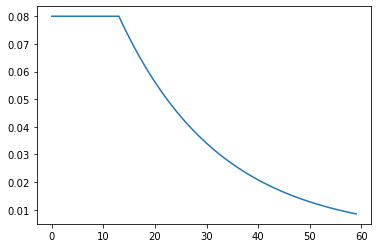

In [40]:
EPOCHS = 60

if strategy.num_replicas_in_sync == 1: # GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    START_LR = 0.01
    MAX_LR = 0.01
    MIN_LR = 0.01
    LR_RAMP = 0 # epochs
    LR_SUSTAIN = 0 #epochs
    LR_DECAY = 1
    
elif strategy.num_replicas_in_sync == 8: # single TPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync # use 32 on TPUv3
    VALIDATION_BATCH_SIZE = 256
    START_LR = 0.01
    MAX_LR = 0.01 * strategy.num_replicas_in_sync
    MIN_LR = 0.001
    LR_RAMP = 0 # epochs
    LR_SUSTAIN = 13 # epochs
    LR_DECAY = .95

else: # TPU pod
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync  # Gobal batch size.
    VALIDATION_BATCH_SIZE = 256
    START_LR = 0.06
    MAX_LR = 0.012 * strategy.num_replicas_in_sync
    MIN_LR = 0.01
    LR_RAMP = 5 # epochs
    LR_SUSTAIN = 8 # epochs
    LR_DECAY = 0.95

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

IMAGE_SIZE = [331, 331] # supported images sizes: 192x192, 331x331, 512,512
                        # make sure you load the appropriate dataset on the next line
#GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
#GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec'
VALIDATION_SPLIT = 0.19

def lrfn(epoch):
    if LR_RAMP > 0 and epoch < LR_RAMP:  # linear ramp from START_LR to MAX_LR
        lr = (MAX_LR - START_LR)/(LR_RAMP*1.0) * epoch + START_LR
    elif epoch < LR_RAMP + LR_SUSTAIN:  # constant ar MAX_LR
        lr = MAX_LR
    else:  # exponential decay from MAX_LR to MIN_LR
        lr = (MAX_LR - MIN_LR) * LR_DECAY**(epoch-LR_RAMP-LR_SUSTAIN) + MIN_LR
    return lr
    
@tf.function
def lrfn_tffun(epoch):
    return lrfn(epoch)

print("Learning rate schedule:")
rng = [i for i in range(EPOCHS)]
plt.plot(rng, [lrfn(x) for x in rng])
plt.show()

In [41]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout() # bug in tight layout in this version of matplotlib
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout() # bug in tight layout in this version of matplotlib
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout() # bug in tight layout in this version of matplotlib
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def count_data_items(filenames):
    # trick: the number of data items is written in the name of
    # the .tfrec files a flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return int(np.sum(n))

def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # force the image size so that the shape of the tensor is known to Tensorflow
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use TFRecordDataset with
    # num_parallel_calls=AUTOTUNE to read from multiple TFRecord files at once
    # band set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames).with_options(opt)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16) # can be AUTOTUNE in TF 2.1
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def batch_dataset(filenames, batch_size, train):
    dataset = load_dataset(filenames)
    n = count_data_items(filenames)
    
    if train:
        dataset = dataset.repeat() # training dataset must repeat
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(2048)
    else:
        # usually fewer validation files than workers so disable FILE auto-sharding on validation
        if strategy.num_replicas_in_sync > 1: # option not useful if there is no sharding (not harmful either)
            opt = tf.data.Options()
            opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
            dataset = dataset.with_options(opt)
        # validation dataset does not need to repeat
        # also no need to shuffle or apply data augmentation
    if train:
        dataset = dataset.batch(batch_size)
    else:
        # little wrinkle: drop_remainder is NOT necessary but validation on the last
        # partial batch sometimes returns a "nan" loss (probably a bug). You can remove
        # this if you do not care about the validatoin loss.
        dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset, n//batch_size

def get_training_dataset(filenames):
    dataset, steps = batch_dataset(filenames, BATCH_SIZE, train=True)
    return dataset, steps

def get_validation_dataset(filenames):
    dataset, steps = batch_dataset(filenames, VALIDATION_BATCH_SIZE, train=False)
    return dataset, steps

In [43]:
# instantiate datasets
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = len(filenames) - int(len(filenames) * VALIDATION_SPLIT)
train_filenames = filenames[:split]
valid_filenames = filenames[split:]

training_dataset, steps_per_epoch = get_training_dataset(train_filenames)
validation_dataset, validation_steps = get_validation_dataset(valid_filenames)

print("TRAINING   IMAGES: ", count_data_items(train_filenames), ", STEPS PER EPOCH: ", steps_per_epoch)
print("VALIDATION IMAGES: ", count_data_items(valid_filenames), ", STEPS PER EPOCH: ", validation_steps)

# numpy data to test predictions
some_flowers, some_labels = dataset_to_numpy_util(load_dataset(valid_filenames), 160)

TRAINING   IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680 , STEPS PER EPOCH:  2


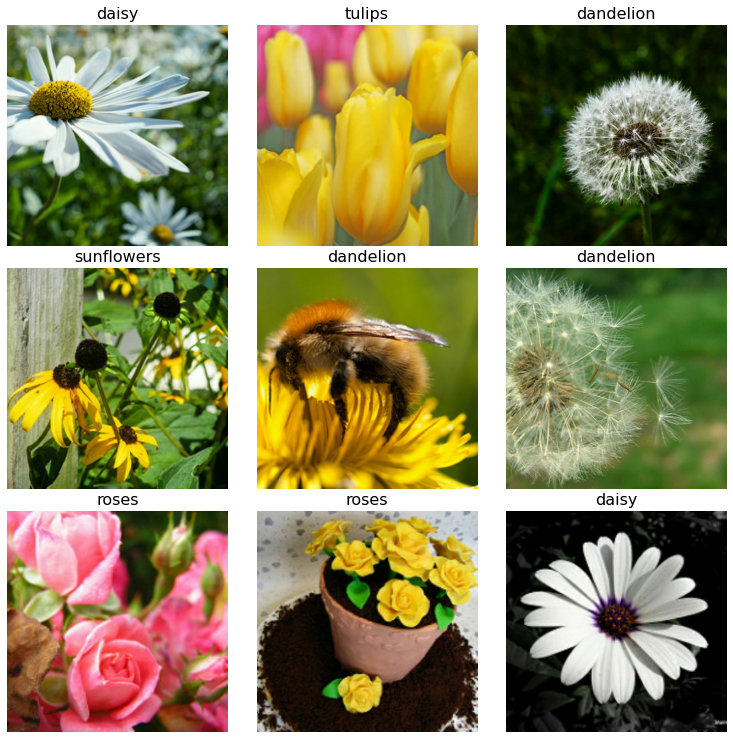

In [44]:
display_9_images_from_dataset(load_dataset(train_filenames))

## The model: squeezenet with 12 layers

In [45]:
def create_model():
    bnmomemtum=0.9 # with only a handful of batches per epoch, the batch norm running average period must be lowered
    def fire(x, squeeze, expand):
        y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation=None, padding='same', use_bias=False)(x)
        y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum, scale=False, center=True)(y)
        y = tf.keras.layers.Activation('relu')(y)
        y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation=None, padding='same', use_bias=False)(y)
        y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum, scale=False, center=True)(y1)
        y1 = tf.keras.layers.Activation('relu')(y1)
        y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation=None, padding='same', use_bias=False)(y)
        y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum, scale=False, center=True)(y3)
        y3 = tf.keras.layers.Activation('relu')(y3)
        return tf.keras.layers.concatenate([y1, y3])

    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    x = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3)) # input is 331x331 pixels RGB
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(48, 96)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(64, 128)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(48, 96)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    y = tf.keras.layers.Dense(5, activation='softmax')(y)
    return tf.keras.Model(x, y)

# Custom learning rate schedule
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn_tffun(epoch=step//steps_per_epoch)

## Instantiate all objects in the strategy scope

In [46]:
with strategy.scope():
    model = create_model()
    
    # Instiate optimizer with learning rate schedule
    optimizer = tf.keras.optimizers.SGD(nesterov=True, momentum=0.9, learning_rate=LRSchedule())
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    valid_accuracy = tf.keras.metrics.CategoricalAccuracy()
    loss_fn = lambda labels, probabilities: tf.reduce_mean(tf.keras.losses.categorical_crossentropy(labels, probabilities))
        
    model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 331, 331, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 331, 331, 32) 128         conv2d_64[0][0]                  
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 331, 331, 24) 768         batch_normalization_64[0][0]     
____________________________________________________________________________________________

## Step functions

In [47]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        probabilities = model(images, training=True)
        loss = loss_fn(labels, probabilities)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_accuracy.update_state(labels, probabilities)
    return loss

@tf.function
def valid_step(images, labels):
    probabilities = model(images, training=False)
    loss = loss_fn(labels, probabilities)
    valid_accuracy.update_state(labels, probabilities)
    return loss

## Custom training loop

In [48]:
# distribute the datset according to the strategy
train_dist_ds = strategy.experimental_distribute_dataset(training_dataset)
valid_dist_ds = strategy.experimental_distribute_dataset(validation_dataset)

print("Steps per epoch: ", steps_per_epoch)

epoch = 0
train_losses=[]
start_time = epoch_start_time = time.time()

for step, (images, labels) in enumerate(train_dist_ds):

    # batch losses from all replicas
    loss = strategy.run(train_step, args=(images, labels))
    # reduced to a single number both across replicas and across the bacth size
    loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, loss, axis=None)
    # or use strategy.experimental_local_results(loss) to access the raw set of losses returned from all replicas

    # validation run at the end of each epoch
    if ((step+1) // steps_per_epoch) > epoch:
        valid_loss = []
        for image, labels in valid_dist_ds:
            batch_loss = strategy.run(valid_step, args=(image, labels)) # just one batch
            batch_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, batch_loss, axis=None)
            valid_loss.append(batch_loss.numpy())
        valid_loss = np.mean(valid_loss)

        epoch = (step+1) // steps_per_epoch
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH: ', epoch)
        print('time: {:0.1f}s'.format(epoch_time),
              ', loss: ', loss.numpy(),
              ', accuracy_: ', train_accuracy.result().numpy(),
              ', val_loss: ', valid_loss,
              ', val_acc_: ', valid_accuracy.result().numpy(),
              ', lr: ', lrfn(epoch)
             )
        
        epoch_start_time = time.time()
        train_accuracy.reset_states()
        valid_accuracy.reset_states()
        if epoch >= EPOCHS:
            break
            
    train_losses.append(loss)
    print('=', end='')
    
training_time = time.time() - start_time
print("TOTAL TRAINING TIME: {:0.1f}s".format(training_time))

Steps per epoch:  23
EPOCH:  1
time: 30.4s , loss:  1.4334767 , accuracy_:  0.3410326 , val_loss:  15.858542 , val_acc_:  0.31640625 , lr:  0.08
EPOCH:  2
time: 6.3s , loss:  1.3821951 , accuracy_:  0.4269701 , val_loss:  1.7522682 , val_acc_:  0.41210938 , lr:  0.08
EPOCH:  3
time: 6.4s , loss:  1.2119173 , accuracy_:  0.48980978 , val_loss:  1.0965786 , val_acc_:  0.55078125 , lr:  0.08
EPOCH:  4
time: 6.3s , loss:  1.1840017 , accuracy_:  0.50203806 , val_loss:  1.4068894 , val_acc_:  0.546875 , lr:  0.08
EPOCH:  5
time: 6.4s , loss:  1.195077 , accuracy_:  0.5397419 , val_loss:  1.0582371 , val_acc_:  0.61328125 , lr:  0.08
EPOCH:  6
time: 6.4s , loss:  1.2365143 , accuracy_:  0.5366848 , val_loss:  1.1563458 , val_acc_:  0.5390625 , lr:  0.08
EPOCH:  7
time: 6.4s , loss:  1.0365884 , accuracy_:  0.5563859 , val_loss:  1.0324206 , val_acc_:  0.5878906 , lr:  0.08
EPOCH:  8
time: 6.4s , loss:  0.9929815 , accuracy_:  0.5553669 , val_loss:  1.1894252 , val_acc_:  0.58203125 , lr:  0.

Detailed training loss:


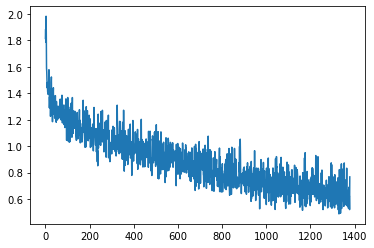

In [49]:
print("Detailed training loss:")
plt.plot(train_losses)
plt.show()

## Predictions
(not distributed)

In [60]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

['sunflowers', 'roses', 'roses', 'dandelion', 'tulips', 'dandelion', 'tulips', 'tulips', 'dandelion', 'tulips', 'tulips', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'tulips', 'roses', 'tulips', 'dandelion', 'sunflowers', 'sunflowers', 'daisy', 'roses', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'roses', 'daisy', 'dandelion', 'roses', 'roses', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'sunflowers', 'tulips', 'roses', 'dandelion', 'dandelion', 'dandelion', 'tulips', 'roses', 'tulips', 'daisy', 'tulips', 'dandelion', 'daisy', 'daisy', 'tulips', 'roses', 'daisy', 'roses', 'dandelion', 'roses', 'dandelion', 'roses', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'tulips', 'tulips', 'tulips', 'dandelion', 'tulips', 'daisy', 'dandelion', 'tulips', 'daisy', 'tulips', 'tulips', 'sunflowers', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'sunflowers', 'dandelion', '

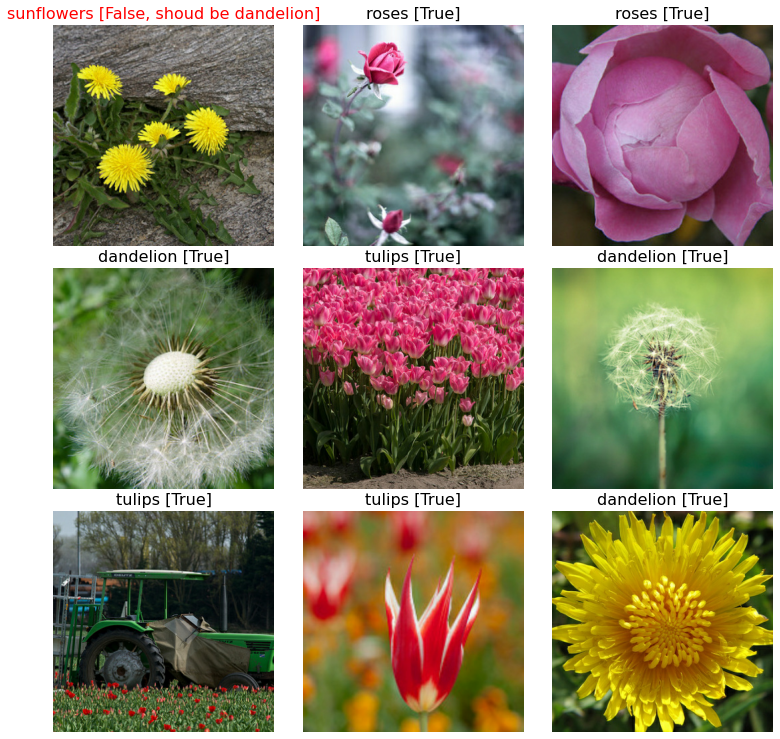

In [61]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
